In [1]:
#Installs Needed
#!pip install opencv-python
#!pip install pillow

In [2]:
print("Booting...")

Booting...


In [3]:
import os
from PIL import Image
import numpy as np

# Path to Image Folder
image_folder = "semantic_drone_dataset/training_set/images1"
image_label_folder = "semantic_drone_dataset/training_set/gt/semantic/label_images1"

# Create an empty list to store the loaded images
images = []
label_images = []

# Set the target size to which you want to resize the images
target_size = (600, 400)  # Resize OG Image Size: (6000,1000)

In [4]:
# Image Folder
for filename in os.listdir(image_folder):
    if filename.endswith(".jpg"): 
        image_path = os.path.join(image_folder, filename)
        image = Image.open(image_path)
        
        image = image.resize(target_size, Image.LANCZOS)
        
        # Convert the image to a NumPy array and append it to the list
        image_array = np.array(image, dtype = np.uint8)
        images.append(image_array)
        
# 'images' now contains NumPy arrays of all the images in the folder

In [5]:
# Image Label Folder
for filename in os.listdir(image_label_folder):
    if filename.endswith(".png"): # Don't Know Why these are pngs...
        image_path = os.path.join(image_label_folder, filename)
        image = Image.open(image_path)
        
        image = image.resize(target_size, Image.LANCZOS)
        
        # Convert the image to a NumPy array and append it to the list
        image_array = np.array(image, dtype = np.uint8)
        label_images.append(image_array)

In [6]:
label_images[0].shape

(400, 600, 3)

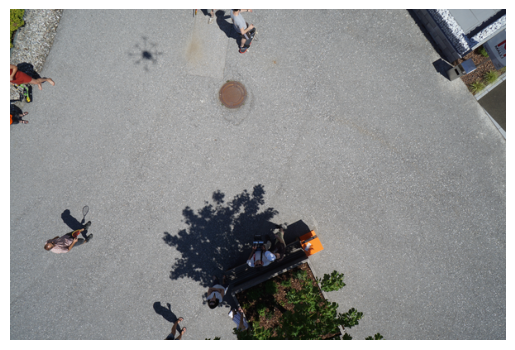

In [7]:
import matplotlib.pyplot as plt

# Display the first image
if images:
    plt.imshow(images[0])
    plt.axis('off')  # Remove axis labels
    plt.show()

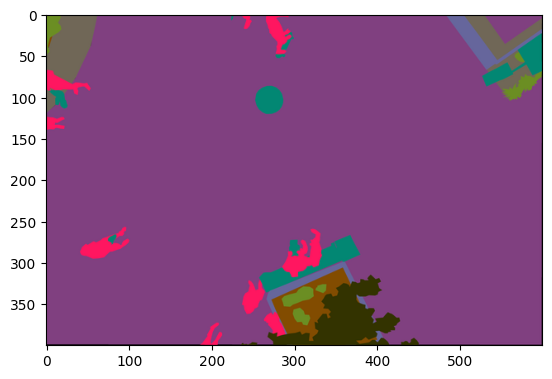

In [8]:
# Display the first label image
if label_images:
    plt.imshow(label_images[0])
    plt.show()

In [9]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Define the paths to your dataset
image_dir = 'semantic_drone_dataset/training_set/images'
label_dir = 'semantic_drone_dataset/training_set/gt/semantic/label_images'

# Load class definitions from the class_dict.csv
class_df = pd.read_csv('semantic_drone_dataset/training_set/gt/semantic/class_dict.csv', index_col=False, skipinitialspace=True)

# Map class names to RGB values
class_dict = {tuple(row[['r', 'g', 'b']].values): row['name'] for _, row in class_df.iterrows()}

In [10]:
# Extract label codes and names
label_codes = [tuple(row[['r', 'g', 'b']].values) for _, row in class_df.iterrows()]
label_names = [class_dict[rgb] for rgb in label_codes]

# Load label images as grayscale images and preprocess them


In [11]:
# Now, label_codes and label_names should be correctly populated
label_codes[:5], label_names[:5]

([(0, 0, 0), (128, 64, 128), (130, 76, 0), (0, 102, 0), (112, 103, 87)],
 ['unlabeled', 'paved-area', 'dirt', 'grass', 'gravel'])

In [12]:
# Split the data into training and validation sets
images_train, images_val, label_images_train, label_images_val = train_test_split(images, label_images, test_size=0.2, random_state=42)

In [13]:
print(len(label_images_train))

1


In [14]:
# Convert the data to NumPy arrays
X_train = np.array(images_train)
X_val = np.array(images_val)

# Define the number of classes (num_classes)
num_classes = len(label_names)
print(num_classes)

24


In [15]:
# Define the input shape for your images
input_shape = (400, 600, 3)   

# Define the model architecture
model = keras.Sequential()

# Add the first convolutional layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))

# Add more convolutional layers
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Add Flatten layer to transition to a fully connected network
model.add(layers.Flatten())

# Add Dense layers for classification
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))  # Dropout for regularization
model.add(layers.Dense(num_classes, activation='softmax'))  # Output layer with num_classes units

In [16]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define the batch size and number of epochs for training
batch_size = 32
epochs = 10

In [17]:
def rgb_to_class(rgb):
    for i, code in enumerate(label_codes):
        if np.array_equal(rgb, code):
            return i
    return -1  # Return -1 if the RGB value is not found



# Convert label images to integer class labels
label_images_train_int = np.array([rgb_to_class(rgb) for rgb in label_images_train])
label_images_val_int = np.array([rgb_to_class(rgb) for rgb in label_images_val])

# Convert integer class labels to one-hot encoded format
Y_train = to_categorical(label_images_train_int, num_classes=num_classes)
Y_val = to_categorical(label_images_val_int, num_classes=num_classes)

In [18]:
print(label_images_train)

[array([[[ 80, 106,  26],
        [111, 148,  36],
        [106, 141,  35],
        ...,
        [119,  59, 119],
        [119,  59, 119],
        [119,  59, 119]],

       [[ 80, 106,  26],
        [111, 148,  36],
        [106, 141,  35],
        ...,
        [130,  65, 130],
        [130,  65, 130],
        [130,  65, 130]],

       [[ 80, 106,  26],
        [111, 148,  36],
        [106, 141,  35],
        ...,
        [128,  64, 128],
        [128,  64, 128],
        [125,  62, 125]],

       ...,

       [[ 69,  34,  69],
        [135,  68, 135],
        [126,  63, 126],
        ...,
        [126,  62, 126],
        [133,  66, 133],
        [ 81,  41,  81]],

       [[ 70,  34,  70],
        [136,  69, 136],
        [127,  64, 127],
        ...,
        [134,  66, 134],
        [142,  70, 142],
        [ 86,  43,  86]],

       [[ 16,   8,  16],
        [ 31,  16,  31],
        [ 29,  15,  29],
        ...,
        [ 82,  41,  82],
        [ 87,  43,  87],
        [ 53,  26,  53]

In [19]:
# Train the model
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, Y_val))

Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 52.1543 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
1/1 [==============================] - 1s 954ms/step - loss: 553.6438 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
1/1 [==============================] - 1s 817ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 1s 900ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 1s 903ms/step - loss: 1736.9448 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 1s 747ms/step - loss: 419.3556 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 1s 772ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val

In [20]:

# Evaluate the model
test_loss, test_acc = model.evaluate(X_val, Y_val)

print(f'Test accuracy: {test_acc}')

1/1 [==============================] - 0s 85ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Test accuracy: 1.0


In [21]:
print(Y_val)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [22]:
predicted_segmentation = model.predict(X_train)

print(predicted_segmentation.shape)

1/1 [==============================] - 0s 167ms/step
(1, 24)


In [23]:
# You can save the model if needed
model.save('semantic_segmentation_model.h5')

C:\Users\Butlerblock\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
print("Done")

Done
